# Dowload the Dataset

In [2]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle competitions download -c Kannada-MNIST

  0% 0.00/818k [00:00<?, ?B/s]
100% 818k/818k [00:00<00:00, 53.7MB/s]
  0% 0.00/33.1k [00:00<?, ?B/s]
100% 33.1k/33.1k [00:00<00:00, 35.1MB/s]
  0% 0.00/1.90M [00:00<?, ?B/s]
100% 1.90M/1.90M [00:00<00:00, 61.5MB/s]
 52% 5.00M/9.71M [00:00<00:00, 7.25MB/s]
100% 9.71M/9.71M [00:00<00:00, 13.3MB/s]


In [4]:
!mkdir dataset
!unzip Dig-MNIST.csv.zip -d dataset
!unzip test.csv.zip -d dataset
!unzip train.csv.zip -d dataset
!cp sample_submission.csv dataset/sample_submission.csv

Archive:  Dig-MNIST.csv.zip
  inflating: dataset/Dig-MNIST.csv   
Archive:  test.csv.zip
  inflating: dataset/test.csv        
Archive:  train.csv.zip
  inflating: dataset/train.csv       


# Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from tensorflow import keras
from keras import backend as K
from keras.utils.vis_utils import plot_model

# Reading and Pre-processing the Dataset

In [6]:
df_all = pd.read_csv('dataset/train.csv')
df_all

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59996,6,0,0,0,0,0,0,0,0,0,0,0,0,147,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59997,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,255,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
df_train_label = df_all.pop('label')
df_train_label

0        0
1        1
2        2
3        3
4        4
        ..
59995    5
59996    6
59997    7
59998    8
59999    9
Name: label, Length: 60000, dtype: int64

In [8]:
df_train_x = df_all/255.0
df_train_x

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.576471,0.192157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078431,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

# Vizualizing some samples

In [9]:
print('Original shape:', df_train_x.shape)
image_height, image_width = 28, 28
num_channels = 1
num_classes = len(df_train_label.unique())
train_examples = len(df_train_x)
df_train_x = df_train_x.values.reshape(train_examples, image_height, image_width, num_channels)
print('Reshaped:', df_train_x.shape)

Original shape: (60000, 784)
Reshaped: (60000, 28, 28, 1)


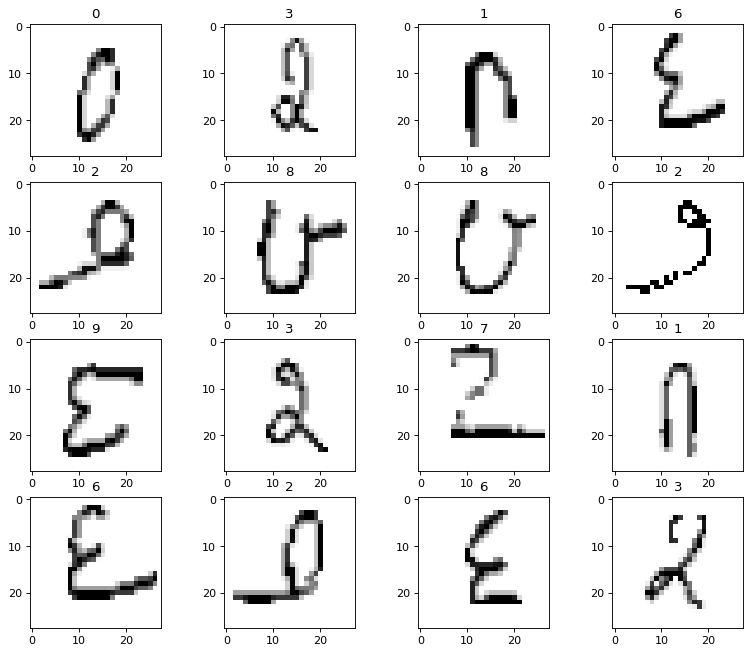

In [14]:
def show_image(img, label, guess = None):
  fig.add_subplot(rows, columns, i)
  plt.title(str(label))
  plt.imshow(image.reshape(image_height, image_width), cmap=plt.cm.binary)

fig = plt.figure(figsize=(12, 10), dpi=80)
columns = 4
rows = 4
for i in range(1, columns*rows + 1):
  sample = random.randint(0, len(df_train_x))
  image = df_train_x[sample]
  label = df_train_label[sample]
  show_image(image, label)
plt.show()

# Setting the Model

In [15]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Flatten, LeakyReLU
from tensorflow.keras.layers import Dense, Dropout, GaussianNoise, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, InputLayer,Conv2D
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.models import Model

from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy

In [93]:
# HYPER-PARAMETERS

LEARNING_RATE = 0.001
EPOCHS = 50
BATCH_SIZE = 512

In [102]:
def build_model():
  model = Sequential(name='Kannada_MNIST')
  # Convolutional + Pooling layers
  model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same',
                    input_shape=(image_height, image_width, num_channels)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))    
  model.add(Flatten())
  # Densely connected layers
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.3))
  model.add(GaussianNoise(1.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(GaussianNoise(1.0))
  # output layer
  model.add(Dense(num_classes, activation='softmax'))

  optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

  model.compile(loss = SparseCategoricalCrossentropy(),
                optimizer = optimizer,
                metrics = ["accuracy"])
  return model

In [103]:
K.clear_session()
model = build_model()
print("Model Created and Compiled!")
model.summary()

Model Created and Compiled!
Model: "Kannada_MNIST"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)        

## Checking Model's Structure

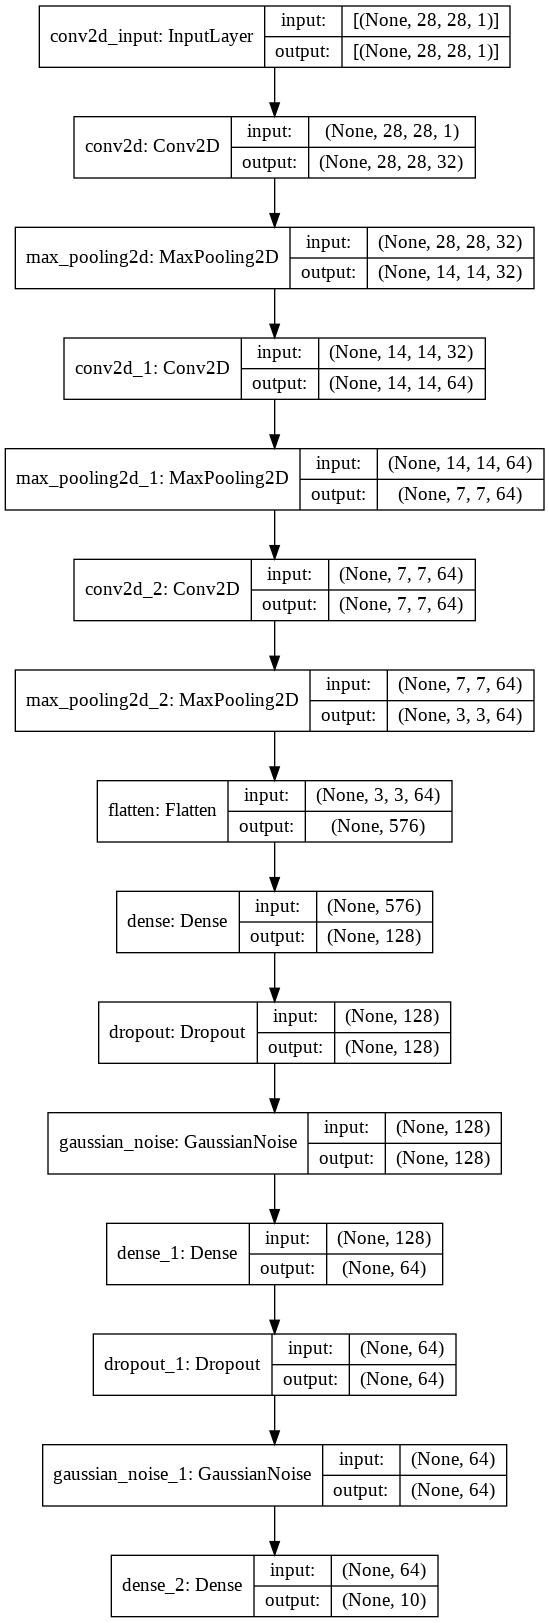

In [114]:
# Tá dando erro msm
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Training the Model

In [104]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.3,
    patience=8,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=25,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [105]:
tf.random.set_seed(123)

history = model.fit(
  df_train_x, df_train_label.values,
  epochs=EPOCHS,
  batch_size=BATCH_SIZE,
  verbose=1,
  validation_split = 0.15,
  callbacks = [reduce_lr])

Epoch 1/50
100/100 [==============================] - 4s 31ms/step - loss: 1.6790 - accuracy: 0.5216 - val_loss: 0.0730 - val_accuracy: 0.9778
Epoch 2/50
100/100 [==============================] - 3s 27ms/step - loss: 0.2696 - accuracy: 0.9203 - val_loss: 0.0456 - val_accuracy: 0.9852
Epoch 3/50
100/100 [==============================] - 3s 27ms/step - loss: 0.1594 - accuracy: 0.9536 - val_loss: 0.0256 - val_accuracy: 0.9914
Epoch 4/50
100/100 [==============================] - 3s 28ms/step - loss: 0.1158 - accuracy: 0.9672 - val_loss: 0.0299 - val_accuracy: 0.9907
Epoch 5/50
100/100 [==============================] - 3s 28ms/step - loss: 0.0926 - accuracy: 0.9742 - val_loss: 0.0446 - val_accuracy: 0.9880
Epoch 6/50
100/100 [==============================] - 3s 28ms/step - loss: 0.0816 - accuracy: 0.9774 - val_loss: 0.0219 - val_accuracy: 0.9932
Epoch 7/50
100/100 [==============================] - 3s 28ms/step - loss: 0.0682 - accuracy: 0.9807 - val_loss: 0.0254 - val_accuracy: 0.9928

In [106]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist_smaller = pd.concat([hist[:5], hist[-5:]])
hist_smaller

,loss,accuracy,val_loss,val_accuracy,lr,epoch
0,1.678986,0.521588,0.073015,0.977778,0.001000,0
1,0.269598,0.920255,0.045553,0.985222,0.001000,1
2,0.159382,0.953588,0.025613,0.991444,0.001000,2
3,0.115849,0.967216,0.029906,0.990667,0.001000,3
4,0.092605,0.974216,0.044553,0.988000,0.001000,4
45,0.009240,0.997373,0.039254,0.994111,0.000027,45
46,0.009647,0.996922,0.039884,0.994222,0.000008,46
47,0.008376,0.997412,0.039845,0.994333,0.000008,47
48,0.008323,0.997314,0.039370,0.994111,0.000008,48
49,0.008618,0.997314,0.040291,0.994111,0.000008,49


In [107]:
print('Max Train Set Accuracy:', max(hist_smaller['accuracy']))
print('Max Dev Set Accuracy:', max(hist_smaller['val_accuracy']))

Max Train Set Accuracy: 0.9974117875099182
Max Dev Set Accuracy: 0.9943333268165588


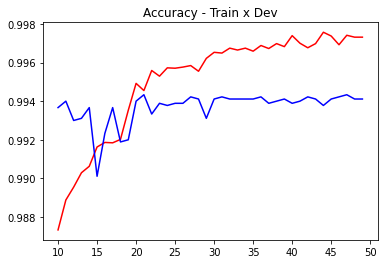

In [108]:
from_epoch = 10
plt.title('Accuracy - Train x Dev')
plt.plot(hist['accuracy'][from_epoch:], 'r')
plt.plot(hist['val_accuracy'][from_epoch:], 'b')

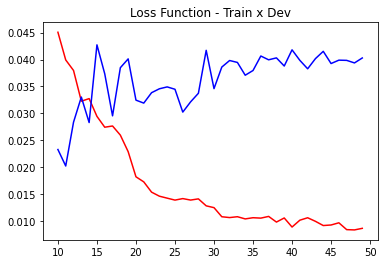

In [109]:
from_epoch = 10
plt.title('Loss Function - Train x Dev')
plt.plot(hist['loss'][from_epoch:], 'r')
plt.plot(hist['val_loss'][from_epoch:], 'b')

# Testing in Harder Kannada MNIST

In [110]:
df_test_harder_MNIST = pd.read_csv('dataset/Dig-MNIST.csv')
df_test_harder_MNIST_label = df_test_harder_MNIST.pop('label')
df_test_harder_MNIST_x = df_test_harder_MNIST/255.0
print('Original shape:', df_test_harder_MNIST_x.shape)
test_examples = len(df_test_harder_MNIST_x)
df_test_harder_MNIST_x = df_test_harder_MNIST_x.values.reshape(test_examples, image_height, image_width, num_channels)
print('Reshaped:', df_test_harder_MNIST_x.shape)
results = model.evaluate(df_test_harder_MNIST_x,  df_test_harder_MNIST_label, batch_size=512)
print("test loss, test acc:", results)

Original shape: (10240, 784)
Reshaped: (10240, 28, 28, 1)
20/20 [==============================] - 0s 12ms/step - loss: 2.0593 - accuracy: 0.7745
test loss, test acc: [2.0592870712280273, 0.7745116949081421]


# Generating Output

In [111]:
df_test_x = pd.read_csv('dataset/test.csv')
df_test_x.pop('id')
df_text_x = df_test_x/255.0
print('Original shape:', df_test_x.shape)
test_examples = len(df_test_x)
df_test_x = df_test_x.values.reshape(test_examples, image_height, image_width, num_channels)
print('Reshaped:', df_test_x.shape)
results = model.predict(df_test_x)
results.shape

Original shape: (5000, 784)
Reshaped: (5000, 28, 28, 1)


(5000, 10)

In [112]:
results = np.argmax(results, axis=1)
submission = pd.read_csv('dataset/sample_submission.csv')
submission['label'] = results
submission

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7
...,...,...
4995,4995,1
4996,4996,1
4997,4997,1
4998,4998,6


In [113]:
submission.to_csv("submission.csv", index=False)